# NHL Canucks - Retention Score Distribution
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 28, 2022

In [232]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [241]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [234]:
lkupclientid = 7 # canucks
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCanucks].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(32915, 54)

### We should specify the features used in our model:

In [235]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (23643, 9)
Unseen Data For Predictions: (4172, 9)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [236]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [269]:
model_matrix = compare_models(
    fold= 10,
    include= ["gbc","lightgbm","lr","xgboost"],
    n_select=4
)
results = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7954,0.8695,0.8188,0.7939,0.8061,0.5896,0.5900,0.3650
lightgbm,Light Gradient Boosting Machine,0.7805,0.8596,0.7891,0.7887,0.7888,0.5603,0.5604,0.8120
gbc,Gradient Boosting Classifier,0.7520,0.8277,0.7570,0.7637,0.7603,0.5034,0.5035,0.1480
lr,Logistic Regression,0.6092,0.6815,0.7509,0.6000,0.6661,0.2090,0.2176,0.0170


In [294]:
models = []
for idx, m in enumerate(model_matrix):
    
    model = create_model(m)
    final_model = finalize_model(model)
    
    models.append({
        "name": str(results.iloc[idx]["Model"]),
        "model": final_model
    })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5980,0.6617,0.7694,0.5864,0.6656,0.1842,0.1951
1,0.6134,0.6875,0.7789,0.5985,0.6769,0.2158,0.2277
2,0.5930,0.6749,0.7308,0.5869,0.6510,0.1767,0.1829
3,0.6134,0.6954,0.7720,0.5993,0.6748,0.2166,0.2273
4,0.6154,0.7000,0.7711,0.6012,0.6756,0.2208,0.2313
5,0.6154,0.6814,0.7567,0.6035,0.6715,0.2217,0.2300
6,0.6366,0.6968,0.6494,0.6507,0.6500,0.2722,0.2722
7,0.6038,0.6687,0.7596,0.5927,0.6658,0.1971,0.2064
8,0.6033,0.6721,0.7567,0.5926,0.6647,0.1962,0.2051
9,0.5998,0.6766,0.7644,0.5885,0.6650,0.1884,0.1985


### Let's load in our 2021 season data and get retention scores using the model:

In [295]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(5100, 9)

In [296]:
predictions = []
for idx, final_m in enumerate(models):
    
    predictions = (predict_model(final_m['model'], data=df_inference, raw_score=True))
    final_m["predictions"] = predictions

### We can create some histograms to visualize each model distribution:

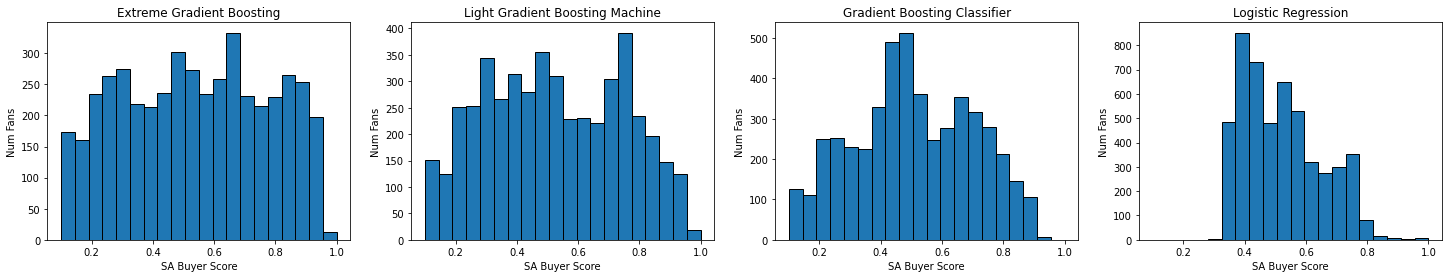

In [381]:
for idx, model in enumerate(models):
    
    plt.subplot(1, 4, idx+1)
    plt.title(model["name"])
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")
    plt.hist(model["predictions"]["Score_1"], bins=20, edgecolor="black", range=(0.1,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### We can also see how many purchases there are in each range of scores:

In [360]:
df_new = pd.DataFrame()

for idx, model in enumerate(models):
    df_new["Score"] = df_new.index
    df_new[str(models[idx]["name"])] = models[idx]["predictions"]["Score_1"].value_counts(bins=np.arange(0, 1, 0.05)).sort_index(ascending=False)

df_new.reset_index(inplace=True, drop=True)
df_new

,Score,Extreme Gradient Boosting,Light Gradient Boosting Machine,Gradient Boosting Classifier,Logistic Regression
0,"(0.9, 0.95]",228,142,29,2
1,"(0.85, 0.9]",307,203,141,14
2,"(0.8, 0.85]",285,214,152,55
3,"(0.75, 0.8]",241,348,329,107
4,"(0.7, 0.75]",263,395,309,507
5,"(0.65, 0.7]",317,263,414,300
6,"(0.6, 0.65]",309,266,265,339
7,"(0.55, 0.6]",263,244,311,565
8,"(0.5, 0.55]",314,343,406,711
9,"(0.45, 0.5]",300,375,674,558
